In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2023-03-08 08:35:02.375273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 08:35:02.506808: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 08:35:02.512036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 08:35:02.512053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
# relative path to the data
data = pd.read_csv('data/processed/wrist_combined.csv')
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-0.511795,-1.180151,-0.441298,-544.572283,107.425153,192.632832
1,Falling,-0.012818,-1.339457,-0.466933,-537.980285,65.797906,144.291513
2,Falling,0.650044,-0.986969,-0.479751,-533.341472,-1.464888,99.246193
3,Falling,1.853999,0.595111,-0.696738,-472.304453,-50.172430,25.757622
4,Falling,1.811884,2.537004,-1.371502,-357.188635,-62.746055,-48.463393


In [4]:
data.shape

(204864, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204864 entries, 0 to 204863
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   204864 non-null  object 
 1   x_acc   204864 non-null  float64
 2   y_acc   204864 non-null  float64
 3   z_acc   204864 non-null  float64
 4   x_gyr   204864 non-null  float64
 5   y_gyr   204864 non-null  float64
 6   z_gyr   204864 non-null  float64
dtypes: float64(6), object(1)
memory usage: 10.9+ MB


In [6]:
# check for null data
data.isnull().sum()

label    0
x_acc    0
y_acc    0
z_acc    0
x_gyr    0
y_gyr    0
z_gyr    0
dtype: int64

In [7]:
# count the datapoints of different activity
data['label'].value_counts()

Walking    72468
Stairs     57156
Running    50424
Sitting    13332
Falling    11484
Name: label, dtype: int64

### Balance this data 

In [8]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204864 entries, 0 to 204863
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   204864 non-null  object 
 1   x_acc   204864 non-null  float64
 2   y_acc   204864 non-null  float64
 3   z_acc   204864 non-null  float64
 4   x_gyr   204864 non-null  float64
 5   y_gyr   204864 non-null  float64
 6   z_gyr   204864 non-null  float64
dtypes: float64(6), object(1)
memory usage: 10.9+ MB


In [10]:
# frame size, Frames per second
Fs = 33

In [11]:
activities = data['label'].value_counts().index

In [12]:
activities

Index(['Walking', 'Stairs', 'Running', 'Sitting', 'Falling'], dtype='object')

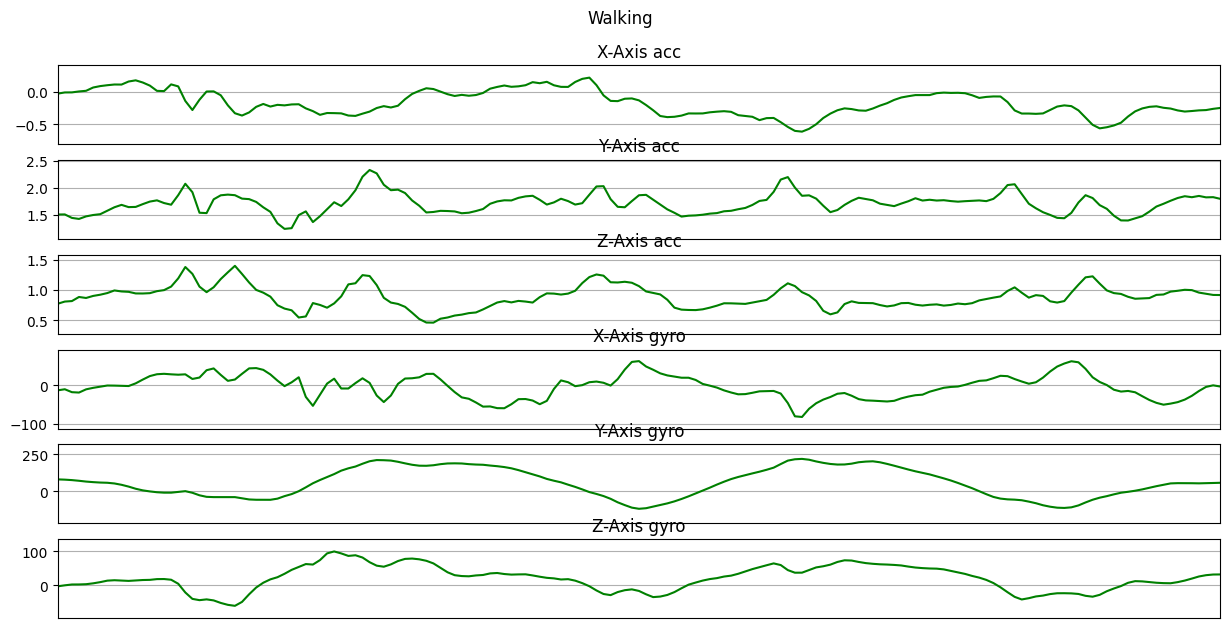

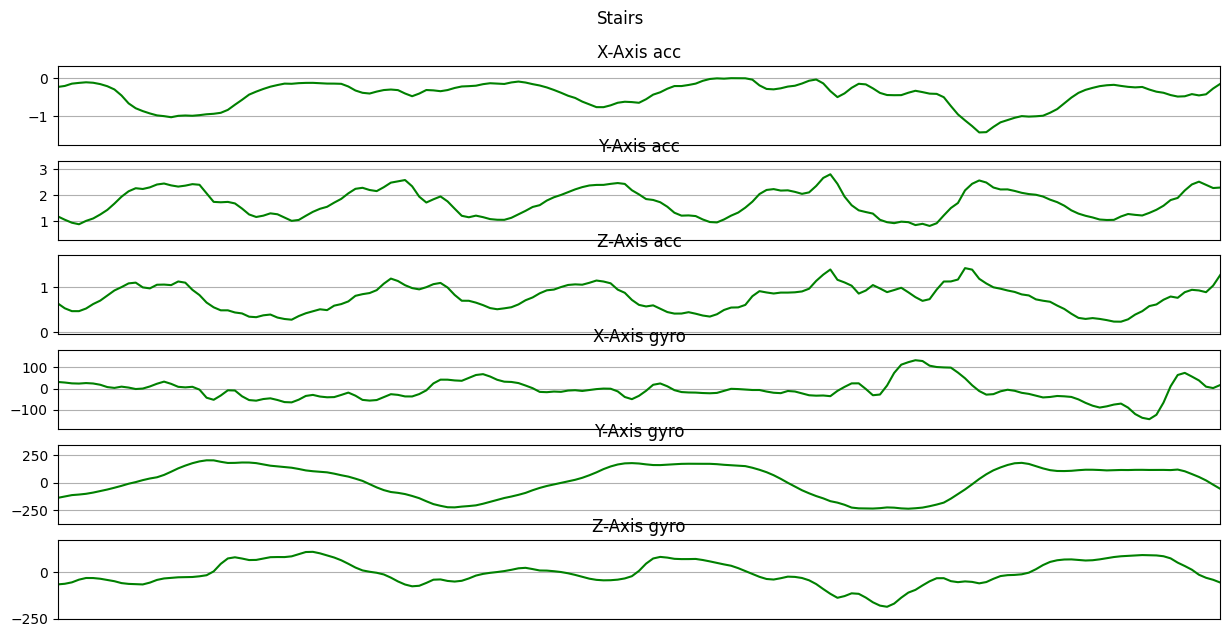

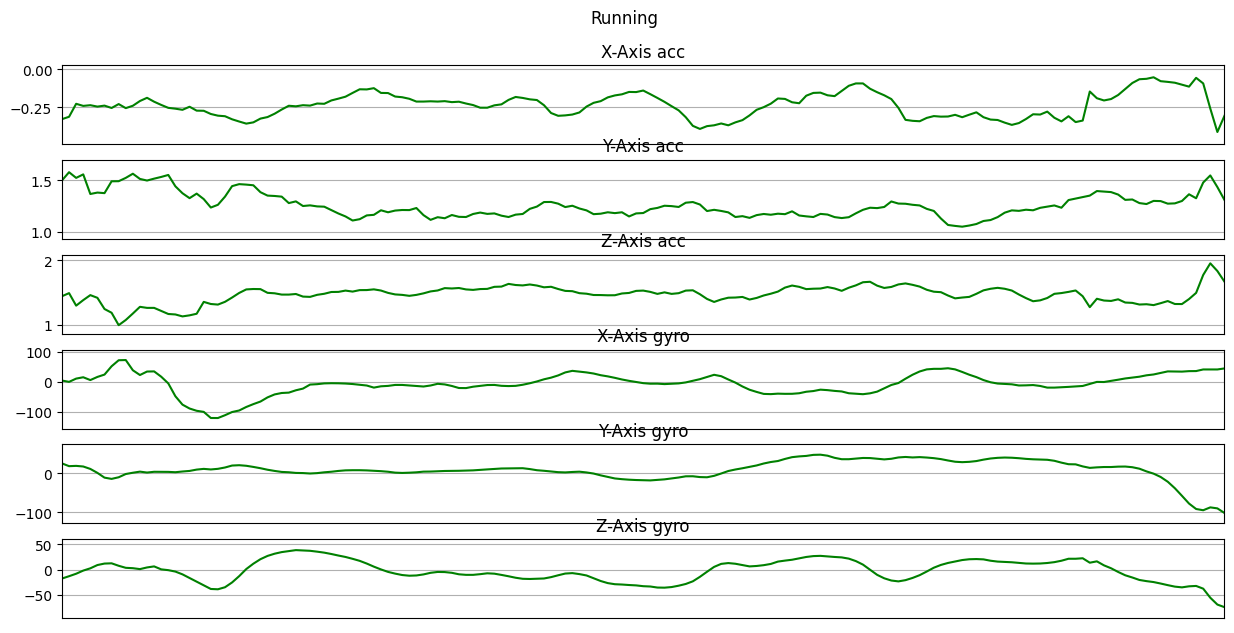

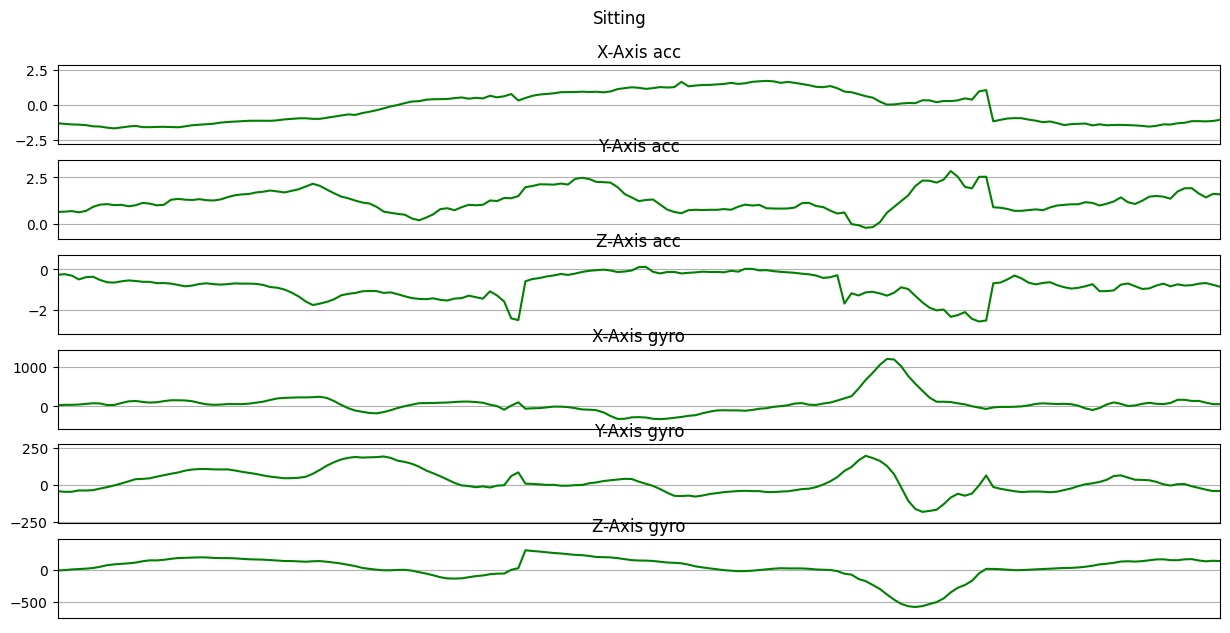

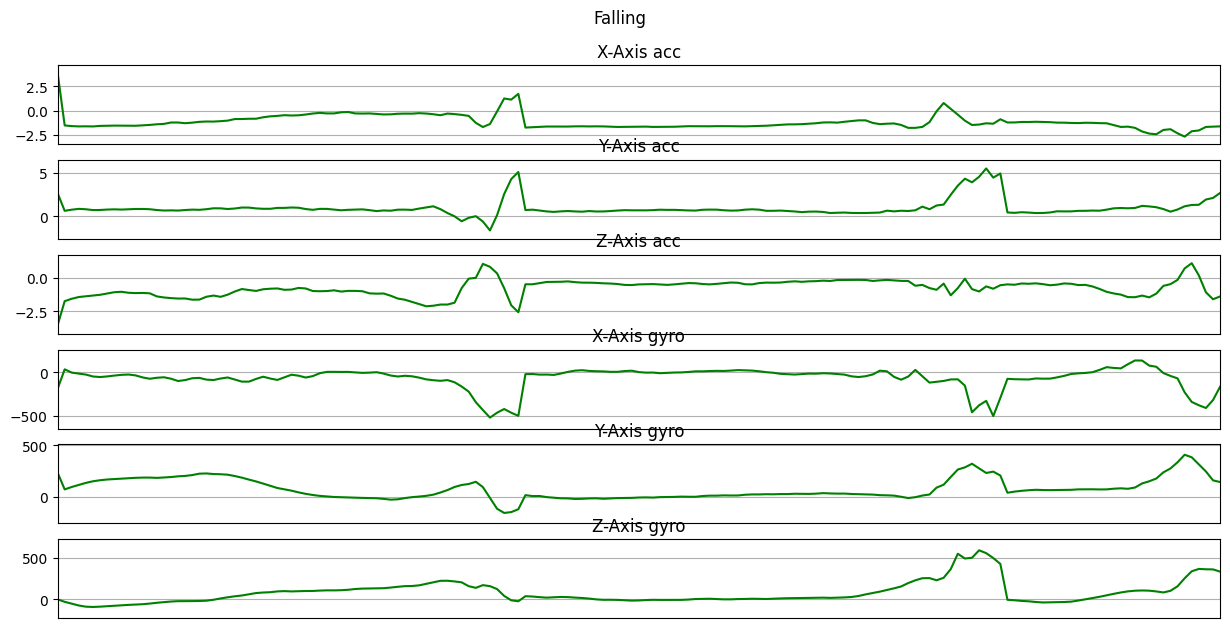

In [13]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(15, 7), sharex=True)
    x_ticks = np.arange(len(data))
    plot_axis(ax0, x_ticks, data['x_acc'], 'X-Axis acc')
    plot_axis(ax1, x_ticks, data['y_acc'], 'Y-Axis acc')
    plot_axis(ax2, x_ticks, data['z_acc'], 'Z-Axis acc')
    plot_axis(ax3, x_ticks, data['x_gyr'], 'X-Axis gyro')
    plot_axis(ax4, x_ticks, data['y_gyr'], 'Y-Axis gyro')
    plot_axis(ax5, x_ticks, data['z_gyr'], 'Z-Axis gyro')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['label'] == activity)][Fs*5:Fs*10]
    plot_activity(activity, data_for_plot)

In [14]:
counts = data['label'].value_counts()
counts

Walking    72468
Stairs     57156
Running    50424
Sitting    13332
Falling    11484
Name: label, dtype: int64

In [15]:
def calculate_class_weights(y):
    import sklearn
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",
                                                    classes = np.unique(y),
                                                    y = y)
    class_weights = dict(zip(np.unique(y), class_weights))
    
    return class_weights

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
data.tail()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
204859,Walking,-1.695608,-0.806604,-0.663778,-40.894803,88.015381,423.352763,4
204860,Walking,-1.919004,-0.800195,-0.660115,-33.204138,84.841456,424.939726,4
204861,Walking,-2.139653,-0.838649,-0.649129,-28.321177,81.789605,411.633656,4
204862,Walking,-2.236702,-0.845973,-0.531938,-29.175695,81.545457,382.335887,4
204863,Walking,-2.227546,-0.835902,-0.379955,-20.630512,77.883236,342.905973,4


In [18]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [19]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']]
y = data['label_id']

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
0,0.198686,-0.856793,-0.857873,-4.798519,0.758672,1.069860,0
1,0.606626,-0.950361,-0.884411,-4.739621,0.461829,0.804122,0
2,1.148549,-0.743329,-0.897680,-4.698174,-0.017820,0.556502,0
3,2.132844,0.185894,-1.122304,-4.152824,-0.365153,0.152527,0
4,2.098412,1.326451,-1.820819,-3.124292,-0.454815,-0.255475,0
...,...,...,...,...,...,...,...
204859,-0.769141,-0.637394,-1.088184,-0.298285,0.620262,2.338156,4
204860,-0.951778,-0.633629,-1.084393,-0.229571,0.597629,2.346879,4
204861,-1.132170,-0.656215,-1.073019,-0.185942,0.575866,2.273734,4
204862,-1.211512,-0.660517,-0.951703,-0.193577,0.574125,2.112681,4


### Frame Preparation 

In [21]:
import scipy.stats as stats

In [22]:
Fs = 33
frame_size = Fs*2
hop_size = Fs*2

In [23]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 6
    frames = []
    labels = []
    for i in range(0, len(df), hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size])[0][0]
        
        # x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr, mag_acc
        frames.append([x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
        labels.append(label)

    # Bring the segments into a shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [24]:
X, y = get_frames(scaled_X, frame_size, hop_size)

/tmp/ipykernel_137570/825593267.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label_id'][i: i + frame_size])[0][0]


In [25]:
X.shape, y.shape

((3104, 66, 6), (3104,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7, stratify = y)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2483, 66, 6)
(2483,)
(621, 66, 6)
(621,)


### LSTM

In [28]:
X_train = X_train.reshape(X_train.shape[0], 66, 6)
X_test = X_test.reshape(X_test.shape[0], 66, 6)

In [51]:
def lstm_model():
    # X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
    # X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
    # X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

    model = Sequential()
    model.add(LSTM(units=128, input_shape= X_train[0].shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=128))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    return model


In [52]:
# calculate class_weight
class_weights = calculate_class_weights(y_train)

# define model
model = lstm_model()

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=13)
          
# compile model
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])    

# train model
history = model.fit(X_train, y_train, validation_split=0.1, epochs = 60, verbose=1, callbacks = [es], class_weight = class_weights)

Epoch 1/60
70/70 [==============================] - 16s 177ms/step - loss: 1.2393 - accuracy: 0.4534 - val_loss: 1.0088 - val_accuracy: 0.6104
Epoch 2/60
70/70 [==============================] - 11s 164ms/step - loss: 0.9094 - accuracy: 0.6124 - val_loss: 0.8737 - val_accuracy: 0.6265
Epoch 3/60
70/70 [==============================] - 11s 163ms/step - loss: 0.6850 - accuracy: 0.6432 - val_loss: 0.7977 - val_accuracy: 0.6466
Epoch 4/60
70/70 [==============================] - 11s 164ms/step - loss: 0.6272 - accuracy: 0.6482 - val_loss: 0.6850 - val_accuracy: 0.6948
Epoch 5/60
70/70 [==============================] - 11s 164ms/step - loss: 0.5858 - accuracy: 0.6732 - val_loss: 0.5984 - val_accuracy: 0.7309
Epoch 6/60
70/70 [==============================] - 12s 167ms/step - loss: 0.4888 - accuracy: 0.6831 - val_loss: 0.5769 - val_accuracy: 0.7229
Epoch 7/60
70/70 [==============================] - 11s 164ms/step - loss: 0.4611 - accuracy: 0.7126 - val_loss: 0.5661 - val_accuracy: 0.7751

In [46]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

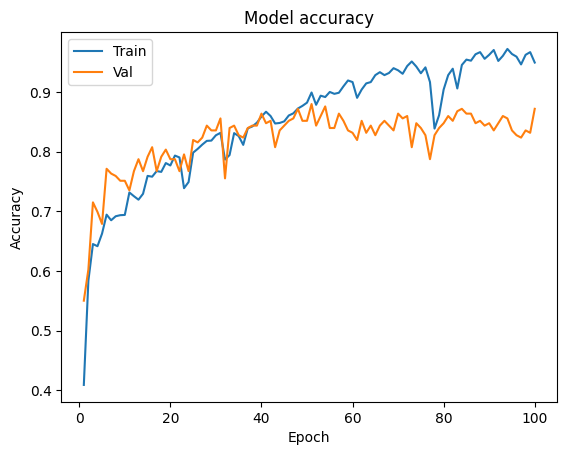

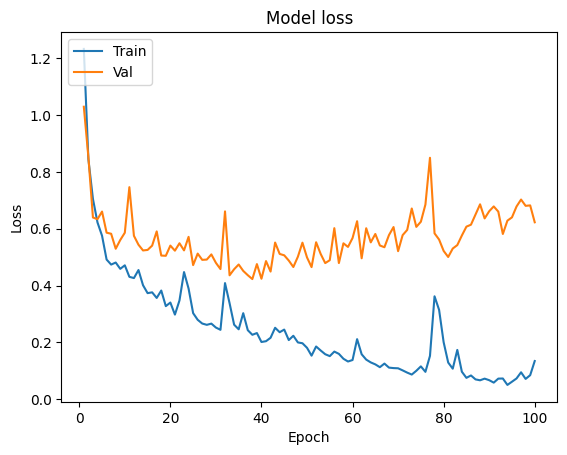

In [49]:
plot_learningCurve(history, epochs=100)

### Confusion Matrix 

In [31]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

20/20 [==============================] - 2s 63ms/step


0.8244766505636071

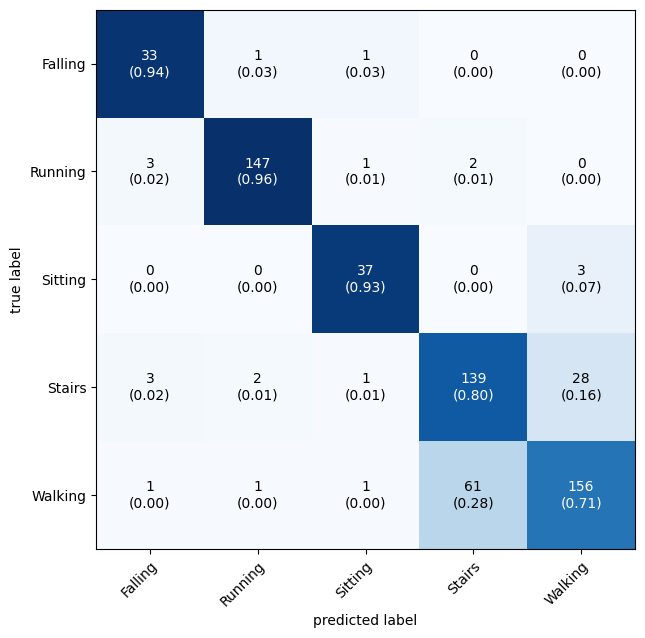

In [53]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [54]:
model.save('models/new/lstm_6_young_wrist.h5')

In [58]:
# model_pretrained = load_model('model.h5')

In [59]:
model_pretrained

In [70]:
# Freeze the layers
for layer in model_pretrained.layers[:]:
    layer.trainable = False

for layer in model_pretrained.layers[2:]:
    layer.trainable = True


In [71]:
for layer in model_pretrained.layers[:]:
    print(layer, layer.trainable)

<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001D2271D9248> False
<tensorflow.python.keras.layers.core.Dropout object at 0x000001D2273290C8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001D227AEA6C8> True
<tensorflow.python.keras.layers.core.Flatten object at 0x000001D227B03B48> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001D227ECD708> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001D22906CC88> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001D229076208> True


In [72]:
model_pretrained.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [73]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model_pretrained.fit(X_train, y_train, epochs = 100, validation_data= (X_val, y_val), verbose=1, callbacks = [es])

Epoch 1/100
116/116 [==============================] - 67s 506ms/step - loss: 0.0765 - accuracy: 0.9728 - val_loss: 0.1990 - val_accuracy: 0.9471
Epoch 2/100
116/116 [==============================] - 60s 520ms/step - loss: 0.0575 - accuracy: 0.9801 - val_loss: 0.2181 - val_accuracy: 0.9428
Epoch 3/100
116/116 [==============================] - 62s 535ms/step - loss: 0.0602 - accuracy: 0.9757 - val_loss: 0.2602 - val_accuracy: 0.9234
Epoch 4/100
116/116 [==============================] - 59s 505ms/step - loss: 0.0962 - accuracy: 0.9635 - val_loss: 0.1915 - val_accuracy: 0.9385
Epoch 5/100
116/116 [==============================] - 59s 511ms/step - loss: 0.0583 - accuracy: 0.9767 - val_loss: 0.2068 - val_accuracy: 0.9471
Epoch 6/100
116/116 [==============================] - 59s 506ms/step - loss: 0.0564 - accuracy: 0.9792 - val_loss: 0.2344 - val_accuracy: 0.9461
Epoch 7/100
116/116 [==============================] - 61s 526ms/step - loss: 0.0540 - accuracy: 0.9824 - val_loss: 0.2462 -

In [74]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

0.9404659188955996

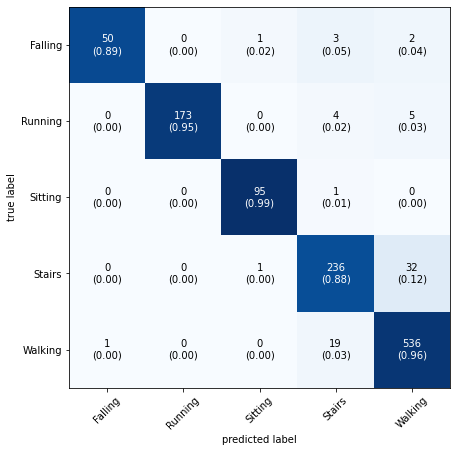

In [75]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)